# Here, we will be performing a grid search to look for the best hyperparameters for our model.


### We will set up our project much like in the previous notebook, but we will will cycle through different regression models and hyperparameters to find the best model for our data.

In [1]:
import numpy as np
import pandas as pd
import sys
import os 
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
import glob

from sglm import utils, glm_fit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Create a project

#### First, let's create a new project. The project directory will create a data and results folder and a config file.

#### You will need to edit the config file with the particular glm params you wish to use. Fields that are necessary to edit are: predictors, predictors_shift_bounds, response, and the glm_keyword_args.

#### You will also need to move your data into the data folder.

In [2]:
project_name = '9010_base'
project_dir = r'E:\Dropbox (BOSTON UNIVERSITY)\2ABT\processed_photometry\9010\9010_base'

utils.create_new_project(project_name, project_dir)

Project directory already exists!


'E:\\Dropbox (BOSTON UNIVERSITY)\\2ABT\\processed_photometry\\9010\\9010_base\\9010_base\\config.yaml'

In [3]:
project_path = os.path.join(project_dir, project_name)
files = os.listdir(project_path)

assert 'data' in files, 'data folder not found! {}'.format(files)
assert 'results' in files, 'results folder not found! {}'.format(files)
assert 'config.yaml' in files, 'config.yaml not found! {}'.format(files)

In [4]:
config_file = os.path.join(project_path, 'config.yaml')
config = utils.load_config(config_file)

# Import and Format Data

Input data should conform to the following convention and be saved as a *.csv:

Indices / Unique Row Identifiers:
* SessionName -- Any order is acceptable
* TrialNumber-- Must be in chronological order, but does not need to start from zero
* Timestamp -- Must be in chronological order, but does not need to start from zero

Columns (Predictors + Responses):
* Predictors - binary
* Reponses - e.g. neural responses (analog or binary)

Example, shown below is dummy data depicting a trial_0 that last four response timestamps:
| SessionName | TrialNumber | Timestamp | predictor_1 | predictor_2 | predictor_3 | response_1 | response_2 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| session_0 | trial_0 | -1 | 0 | 0 | 0 | 1 | 0.3 |
| session_0 | trial_0 | 0 | 0 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_0 | 1 | 0 | 0 | 0 | 1 | 2.3 |
| session_0 | trial_0 | 2 | 0 | 1 | 0 | 1 | 0.3 |
| session_0 | trial_1 | -2 | 0 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_1 | -1 | 0 | 0 | 0 | 1 | 2.3 |
| session_0 | trial_1 | 0 | 1 | 0 | 0 | 0 | 1.4 |
| session_0 | trial_1 | 1 | 0 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_0 | 5 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_0 | 6 | 1 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_0 | 7 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_0 | 8 | 0 | 0 | 0 | 1 | 2.3 |
| session_1 | trial_1 | 9 | 0 | 0 | 0 | 0 | 1.4 |
| session_1 | trial_1 | 10 | 0 | 0 | 0 | 1 | 2.3 |
....

#### If needed, use the following function to combine multiple sessions into one csv. You will need a filename you wish to call your output_csv

In [5]:
output_csv = 'combined.csv'

utils.combine_csvs(project_path, output_csv)

Output file already exists! Please remove or rename the existing file: E:\Dropbox (BOSTON UNIVERSITY)\2ABT\processed_photometry\9010\9010_base\9010_base\data\combined.csv


'E:\\Dropbox (BOSTON UNIVERSITY)\\2ABT\\processed_photometry\\9010\\9010_base\\9010_base\\data\\combined.csv'

#### Next, we'll load the data and set the columns you wish to use as fixed indices. Following this step, you can explore and add features/predictors to the dataframe as needed.

In [6]:
input_file = os.path.join(project_path, 'data', output_csv)
index_col = ['SessionName', 'TrialNumber', 'Timestamp']

df = utils.read_data(input_file, index_col)

print('Your dataframe has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

C:\Users\mwall\Documents\GitHub\sabatini-glm-workflow\sglm\utils.py:45: DtypeWarning: Columns (32,45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file, index_col = index_col)


Your dataframe has 1288665 rows and 80 columns


#### Shift responses and predictors. If you do not want to shift your predictors by an amount you set, feel free to comment out the entire "predictors_shift_bounds" in config.yaml. We will then use the default set when we created the config file. 

#### For, larger datasets, you may want to sparse your training data. You can do this by seeting the sparsify argument to True in the shift_predcitors function.

In [19]:
response_shift, df_predictors_shift, shifted_params = glm_fit.shift_predictors(config, df, sparsify=False)
print('Your dataframe was shifted using: {}'.format(shifted_params))

Your dataframe was shifted using: [('photometryCenterInIndexRt', [-20, 20]), ('photometryCenterInIndexLt', [-20, 20]), ('photometryCenterOutIndexRt', [-20, 20]), ('photometryCenterOutIndexLt', [-20, 20]), ('photometrySideInIndexr', [-20, 20]), ('photometrySideInIndexnr', [-20, 20]), ('photometrySideInIndexRt', [-20, 20]), ('photometrySideInIndexLt', [-20, 20]), ('photometrySideOutIndexRt', [-20, 20]), ('photometrySideOutIndexLt', [-20, 20])]


In [8]:
X_train,X_test, y_train, y_test = glm_fit.split_data(df_predictors_shift, response_shift, config)

print('Training data has {} rows and {} columns'.format(X_train.shape[0], X_train.shape[1]))
print('Testing data has {} rows and {} columns'.format(X_test.shape[0], X_test.shape[1]))

Training data has 1030900 rows and 410 columns
Testing data has 257725 rows and 410 columns


## Now, we will perform a grid search to find the best hyperparameters for our model. We will cycle through different regression models and hyperparameters to find the best model for our data. We will start with ElasticNet, Ridge, and OLS regression models.

In [9]:
pipeline = Pipeline([('regression', ElasticNet())])  # Start with ElasticNet as default

params_elasticnet = {
    'regression': [ElasticNet()],
    'regression__alpha': [0.1, 0.5, 1, 5, 10, 50, 100],  # Regularization strength, please edit.
    'regression__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]  # Mixing parameter for ElasticNet, please edit.
}

# Define parameters for Ridge regression
params_ridge = {
    'regression': [Ridge()],
    'regression__alpha': [0.1, 0.5, 1, 5, 10, 50, 100] # Regularization strength, please edit.
}

params_OLS = {
    'regression': [LinearRegression()]
}

# Combine both parameter grids
params = [params_elasticnet, params_ridge]

# Add common parameters for GridSearchCV
common_params = {
    'estimator': pipeline,
    'param_grid': params,
    'cv': 10,
    'scoring': 'neg_mean_squared_error',  # r2, neg_mean_squared_error
    'refit': True,
    'n_jobs': -2,
    'verbose': 1,
    'return_train_score': True,
}

grid_reg = GridSearchCV(**common_params)
grid_reg.fit(X_train, y_train)

Fitting 10 folds for each of 56 candidates, totalling 560 fits


GridSearchCV(cv=10, estimator=Pipeline(steps=[('regression', ElasticNet())]),
             n_jobs=-2,
             param_grid=[{'regression': [ElasticNet()],
                          'regression__alpha': [0.1, 0.5, 1, 5, 10, 50, 100],
                          'regression__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95,
                                                   0.99, 1]},
                         {'regression': [Ridge()],
                          'regression__alpha': [0.1, 0.5, 1, 5, 10, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [10]:
# Print best parameters and scores
print('Best parameters: {}'.format(grid_reg.best_params_))
print('Best cross-validated score: {:.2f}'.format(grid_reg.best_score_))
print('Test score: {:.2f}'.format(grid_reg.score(X_test, y_test)))
print('Refit time: {:.2f}'.format(grid_reg.refit_time_))

# Save best model and parameters
import pickle
model_path = config['Project']['project_path'] + '/models'
model_name = 'grid_search' + '_model.pkl'
model_full_path = os.path.join(model_path, model_name)
with open(model_full_path, 'wb') as f:
    pickle.dump(grid_reg, f)

Best parameters: {'regression': Ridge(), 'regression__alpha': 1}
Best cross-validated score: -0.80
Test score: -0.80
Refit time: 0.77


In [11]:
# dump the best paramaters to config file
regression_type = grid_reg.best_params_['regression'].__class__.__name__
alpha = grid_reg.best_params_['regression__alpha']

config['glm_params']['regression_type'] = regression_type
if regression_type == 'ElasticNet':
    l1_ratio = grid_reg.best_params_['regression__l1_ratio']
    config['glm_params']['glm_keyword_args']['elasticnet']['alpha'] = alpha
    config['glm_params']['glm_keyword_args']['elasticnet']['l1_ratio'] = l1_ratio
elif regression_type == 'Ridge':
    config['glm_params']['glm_keyword_args']['ridge']['alpha'] = alpha

# save back to config file
cfg_file = os.path.join(project_dir, project_path, "config.yaml")
utils.save_to_yaml(config, cfg_file)


'E:\\Dropbox (BOSTON UNIVERSITY)\\2ABT\\processed_photometry\\9010\\9010_base\\9010_base\\config.yaml'

## Now we can run the recommended regression with the best parameters. 

In [12]:
model, y_pred, score, beta, intercept = glm_fit.fit_glm(config, X_train, X_test, y_train, y_test)

Fitting Ridge model...
Model fit complete


## Save your outputs

In [13]:
#Create your model dictonary, this should include all the information you wish to save
model_dict = {'model': model,
              'model_type': config['glm_params']['regression_type'],
              'y_pred': y_pred,
              'score': score,
              'beta': beta,
              'intercept': intercept,
              }

#Save your model dictionary
glm_fit.save_model(model_dict, config)

## Generate and save figures and results.
The following requires non-sparse data. If you have sparse data, you will need to re-run `shift_predictors` with the `sparse` argument set to `False`.

`plot_and_save` will save scatter plots of the predicted vs actual responses and the residuals and your beta coefficients. 

`plot_betas` will only *plot* the beta coefficients. 

`plot_aligned_dataStream` will plot the aligned data stream (e.g. aligned input data). You will need to run the `align_dataStream` function before running this plot.

`plot_actual_v_reconstructed` will plot the actual vs reconstructed responses. You will need to run the `align_reconstructed_dataStream` function before running this plot.

In [14]:
save_path = os.path.join(project_path, 'results')

In [22]:
glm_fit.plot_and_save(config, y_pred, y_test, beta, df_predictors_shift)

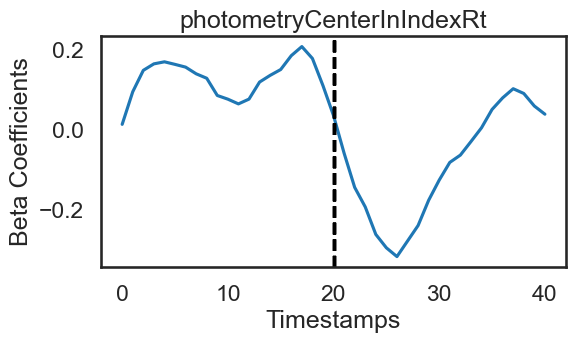

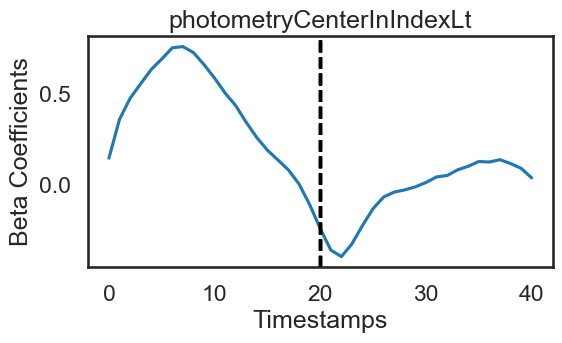

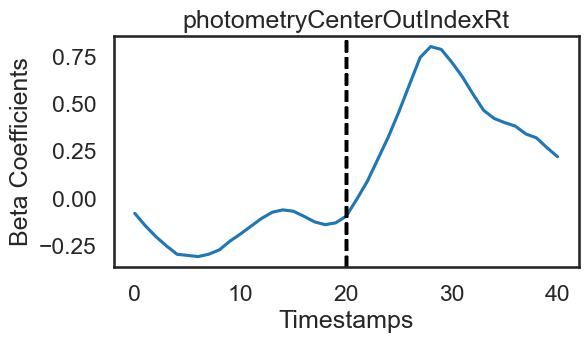

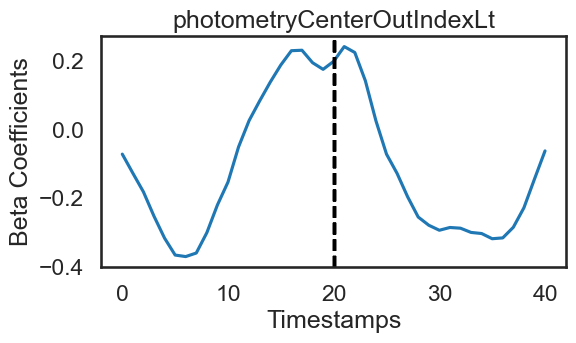

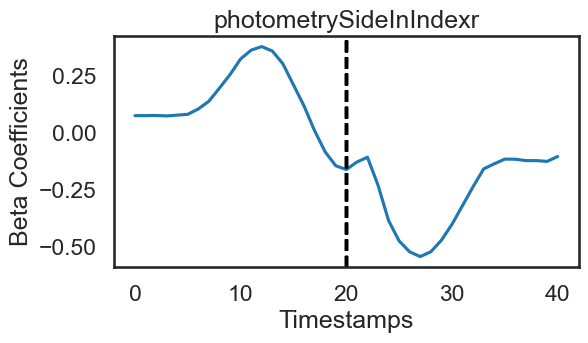

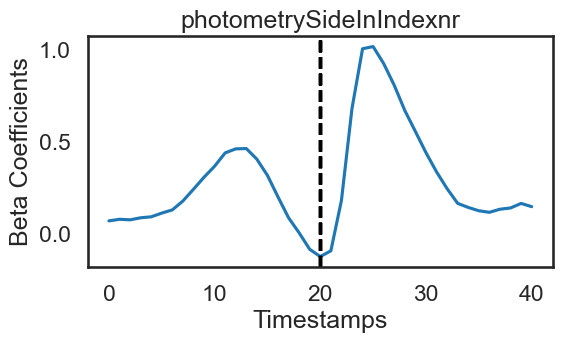

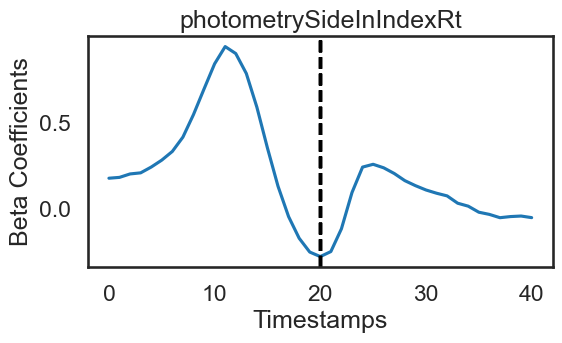

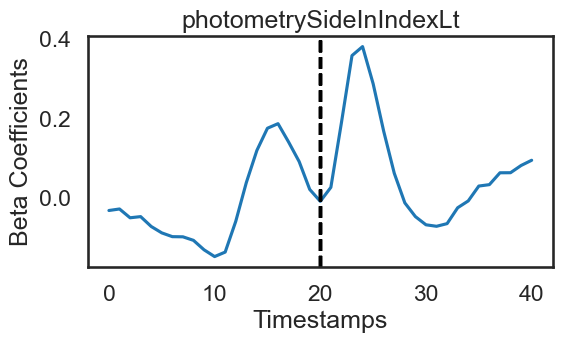

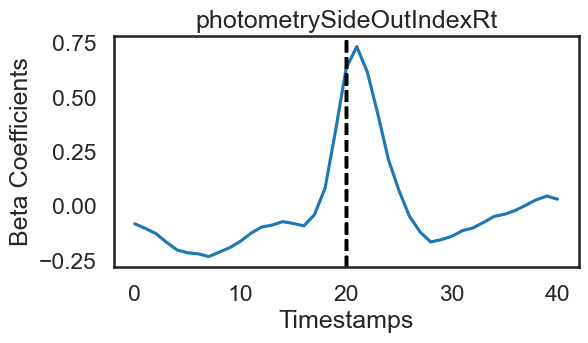

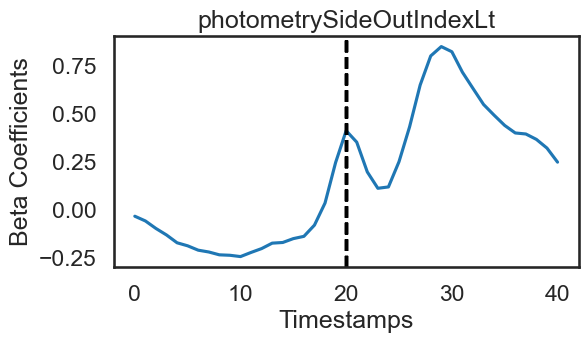

In [23]:
utils.plot_betas(config, beta, df_predictors_shift, shifted_params, save=None, save_path=None)

### Align the data and plot the actual and reconstructed responses (e.g. predicted y) against the true responses (e.g. neural responses) for each prediction. 

100%|█████████████████████████████████████████████████████████████████████████████| 8305/8305 [00:19<00:00, 431.07it/s]


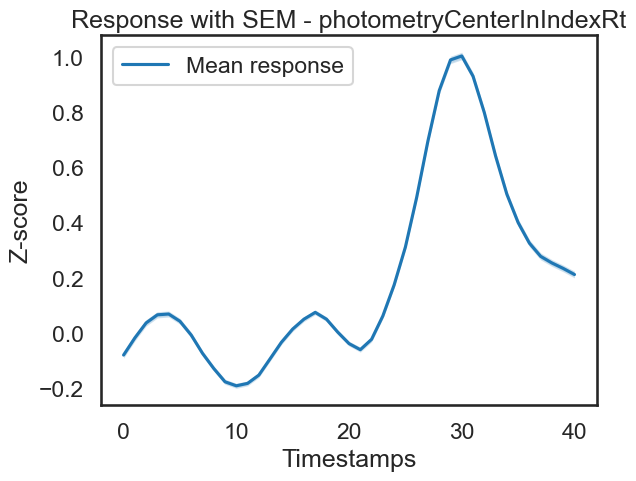

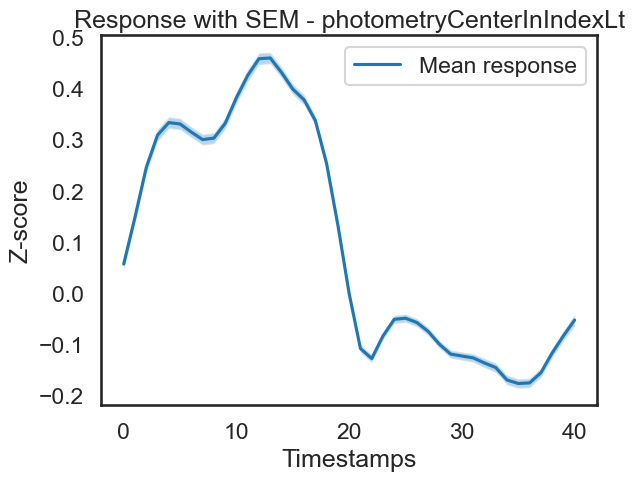

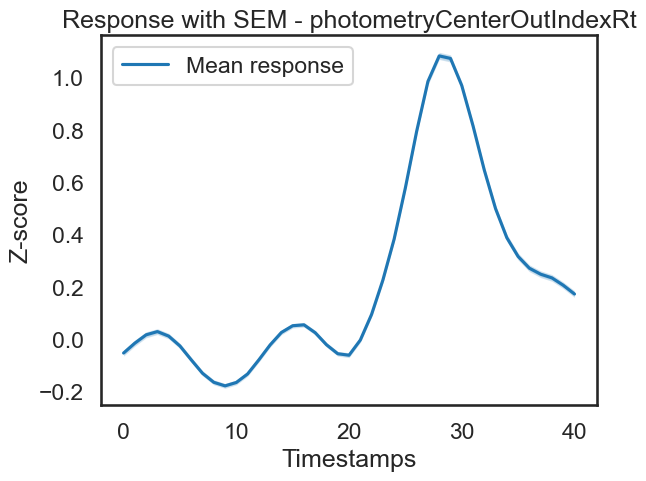

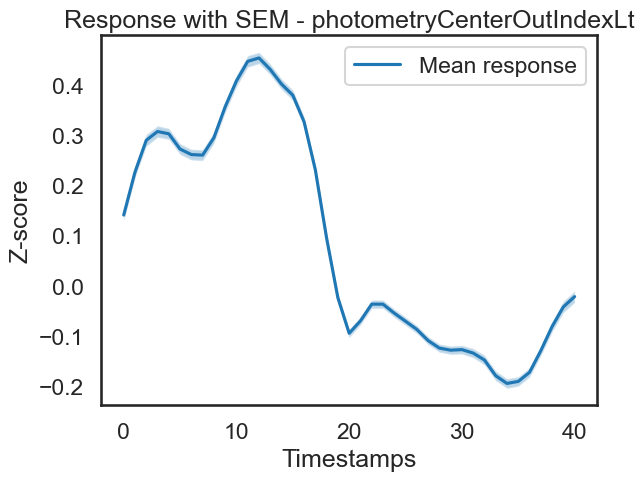

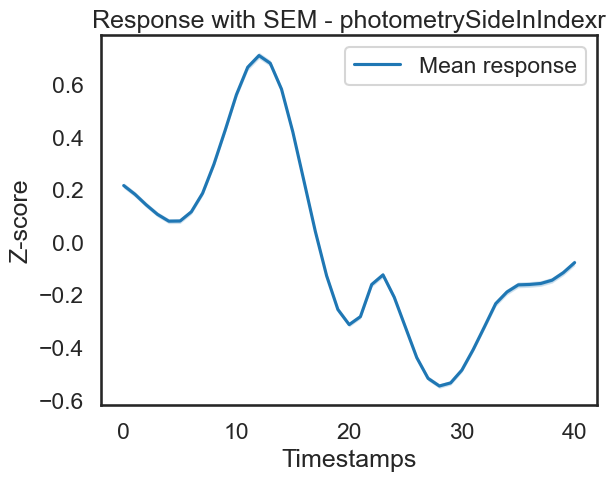

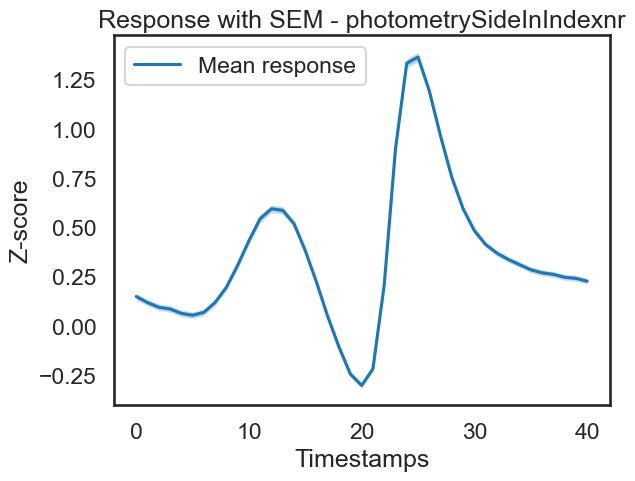

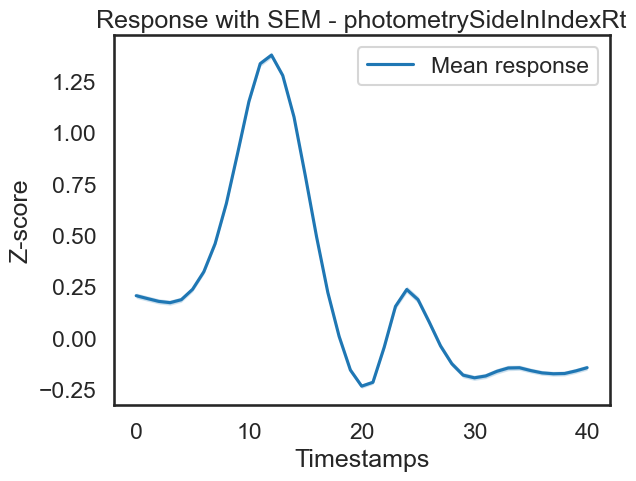

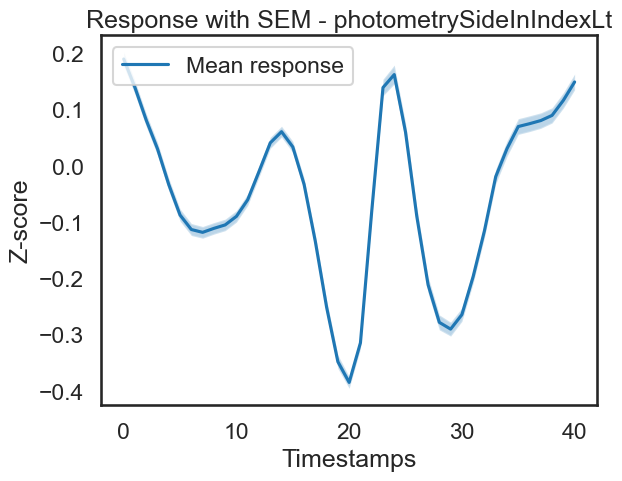

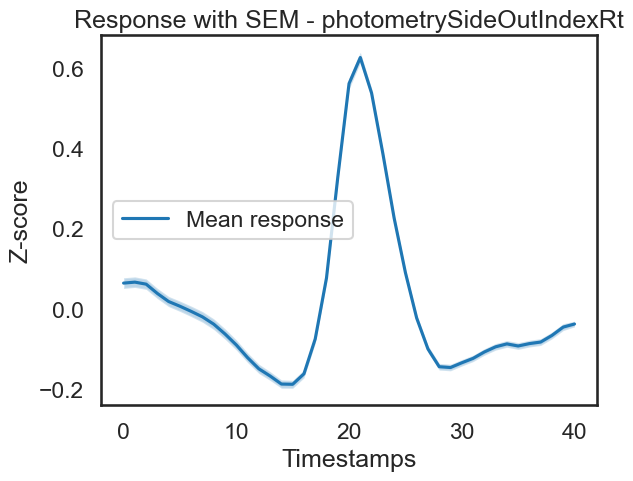

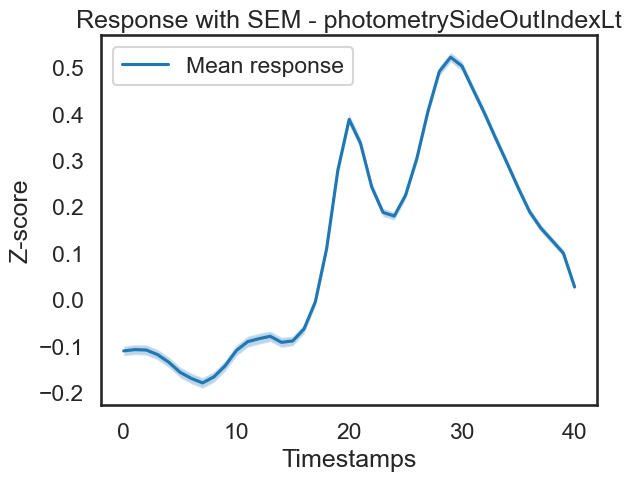

In [24]:
# Align your actual data
aligned_dataStream = utils.align_dataStream(config, df, shifted_params)

# Plot aligned data
utils.plot_aligned_dataStream(aligned_dataStream, config, save=True, save_path=save_path, reconstructed=False)

100%|█████████████████████████████████████████████████████████████████████████████| 8305/8305 [00:19<00:00, 435.83it/s]


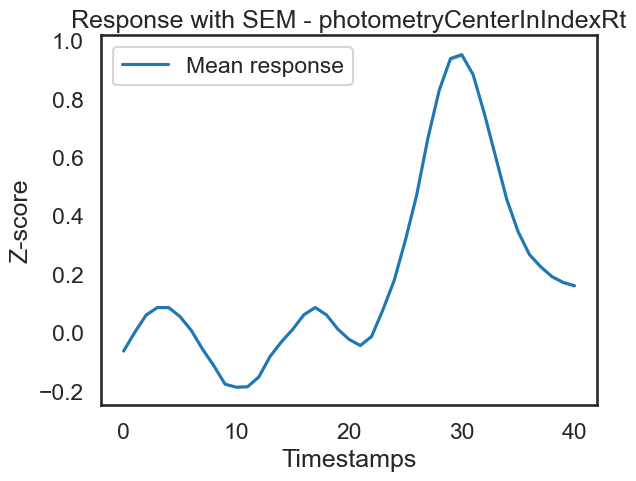

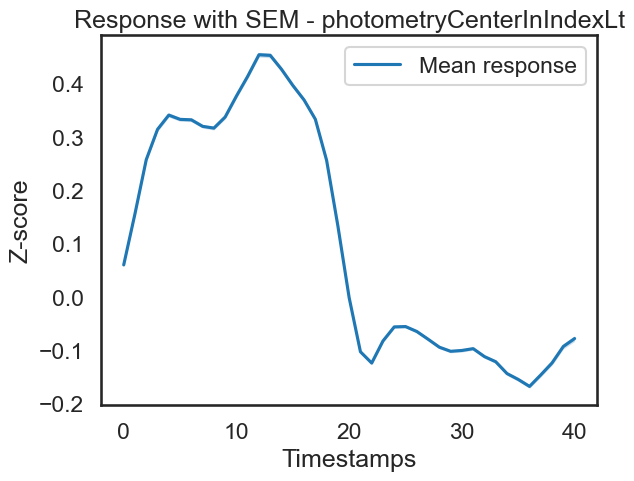

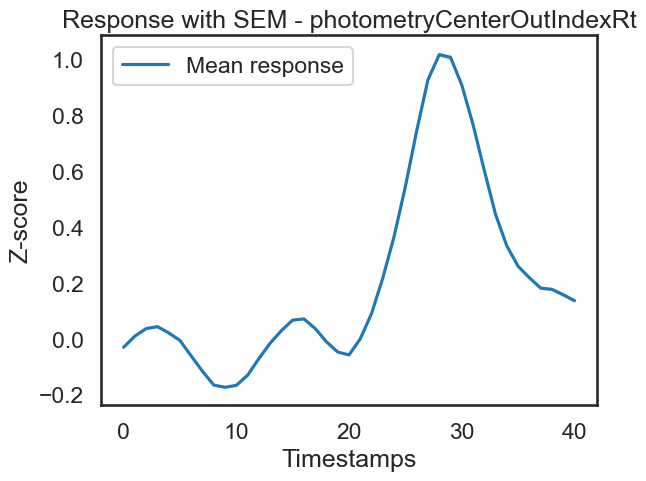

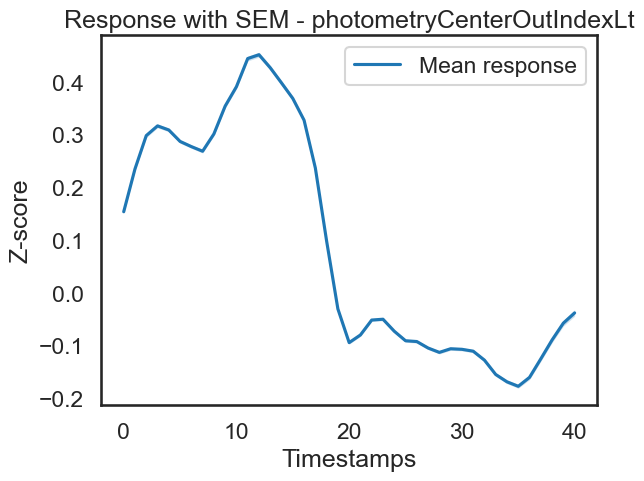

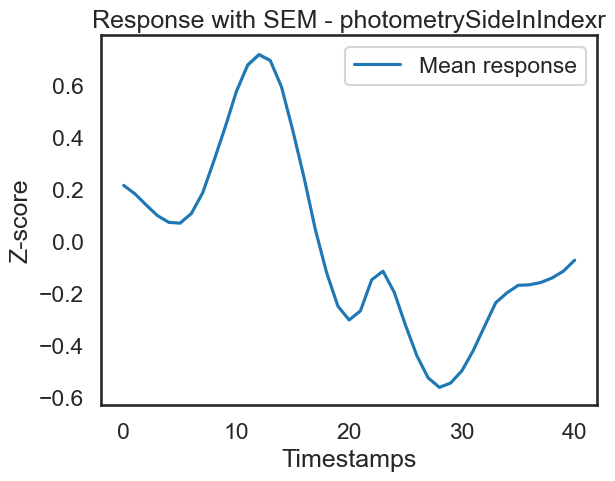

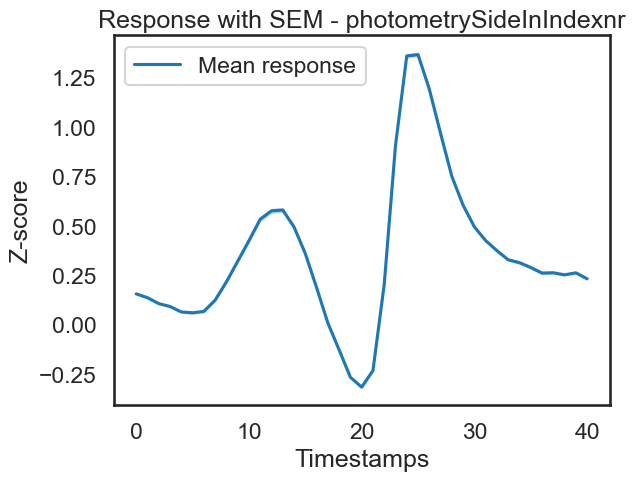

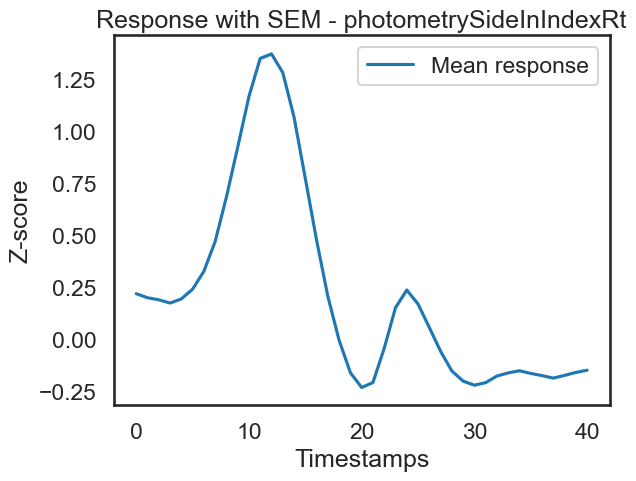

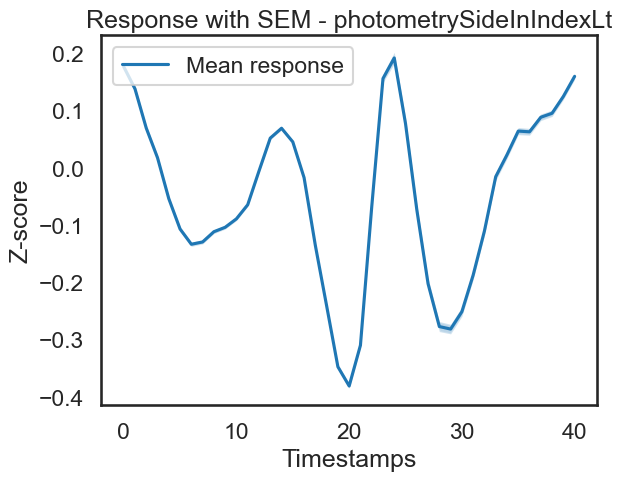

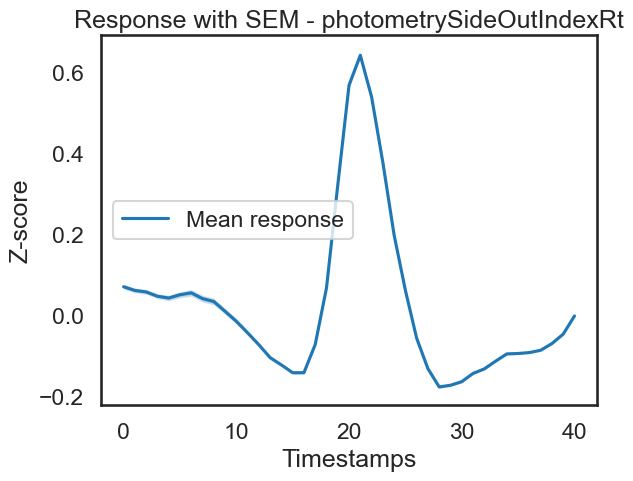

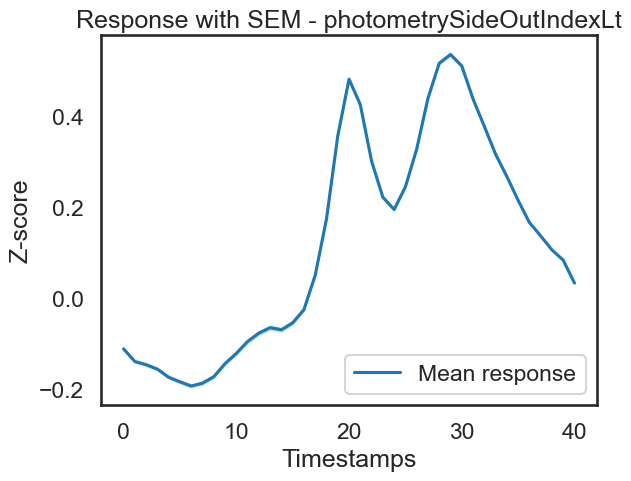

In [25]:
# Reconstruct your signal from your X-inputs
recon_dataStream = utils.align_reconstructed_dataStream(config, 
                                                        df, df_predictors_shift,
                                                         shifted_params, model)

# Plot reconstructed data
utils.plot_aligned_dataStream(recon_dataStream, config, save=True, save_path=save_path, reconstructed=True)

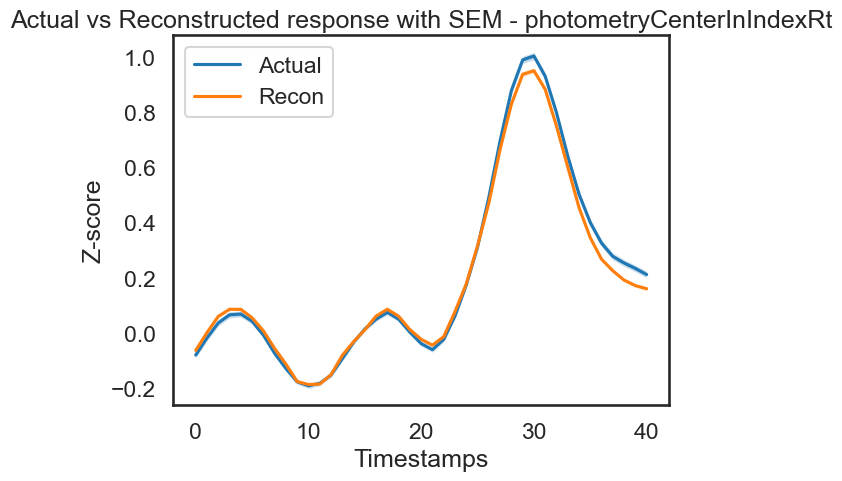

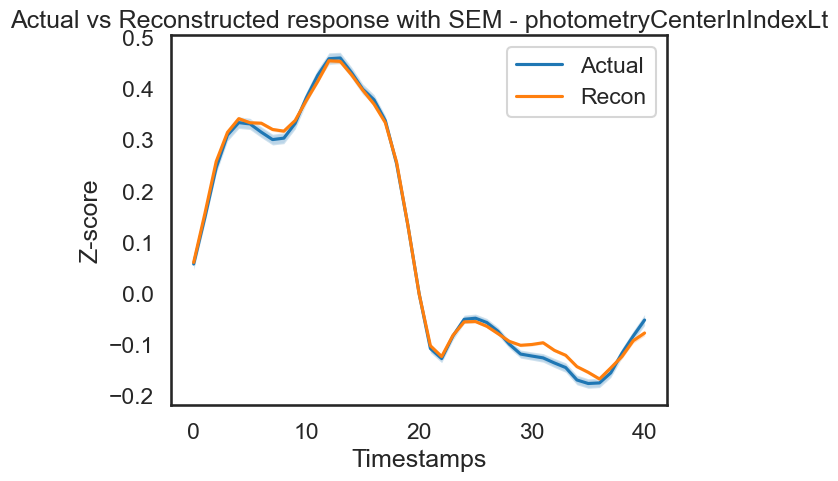

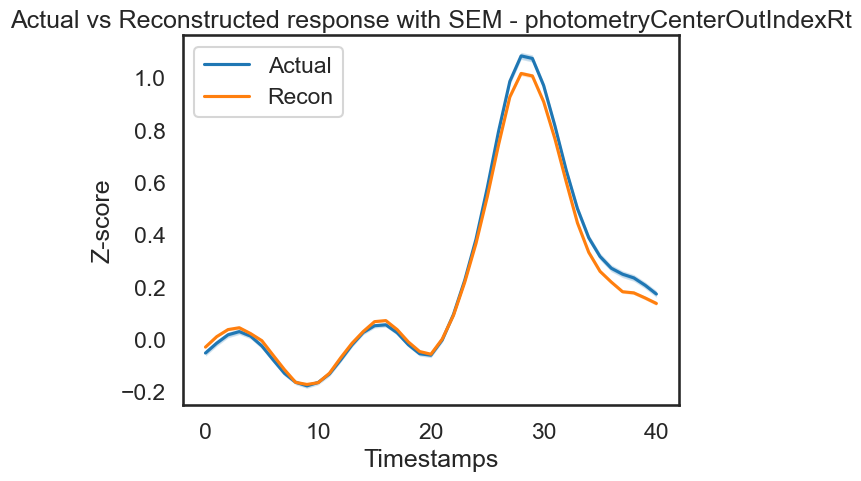

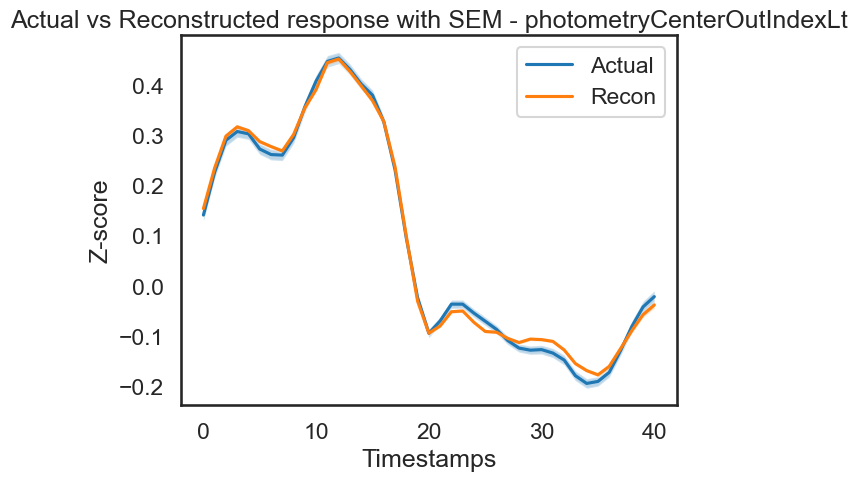

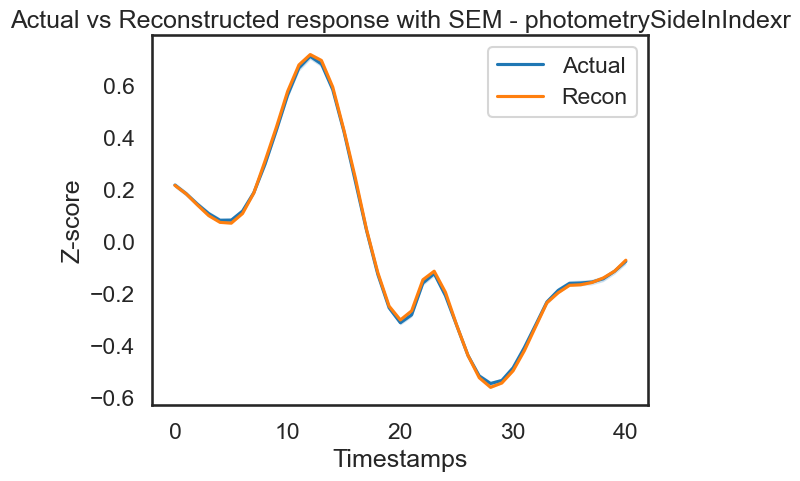

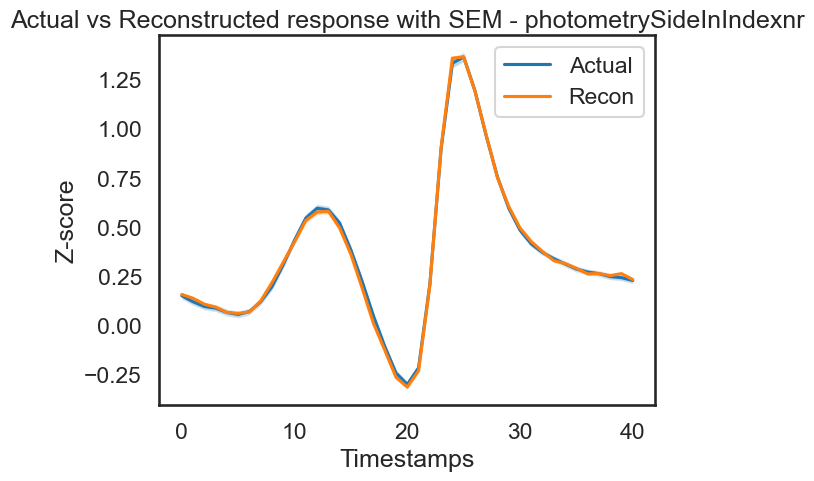

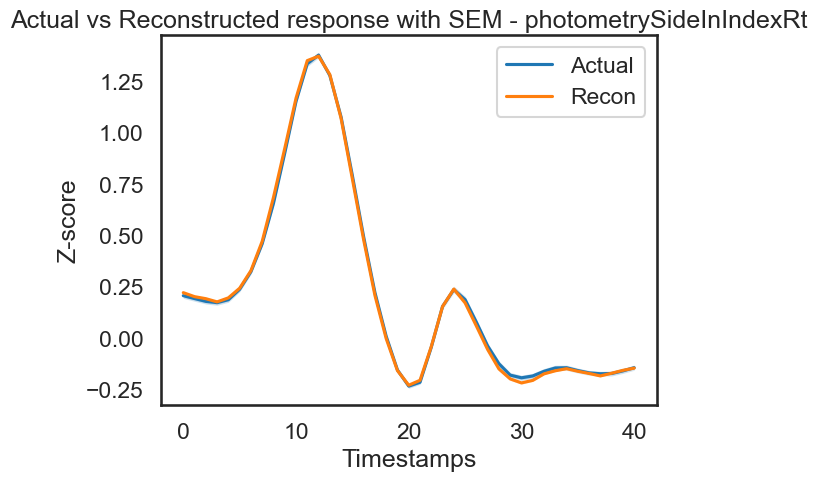

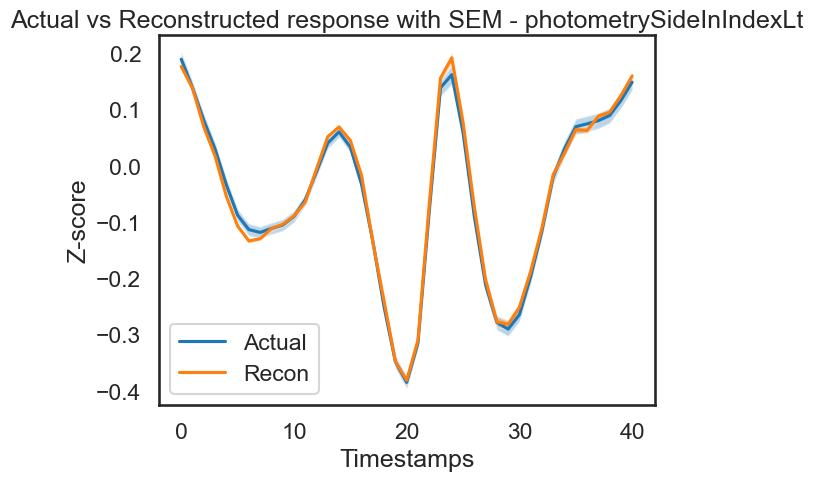

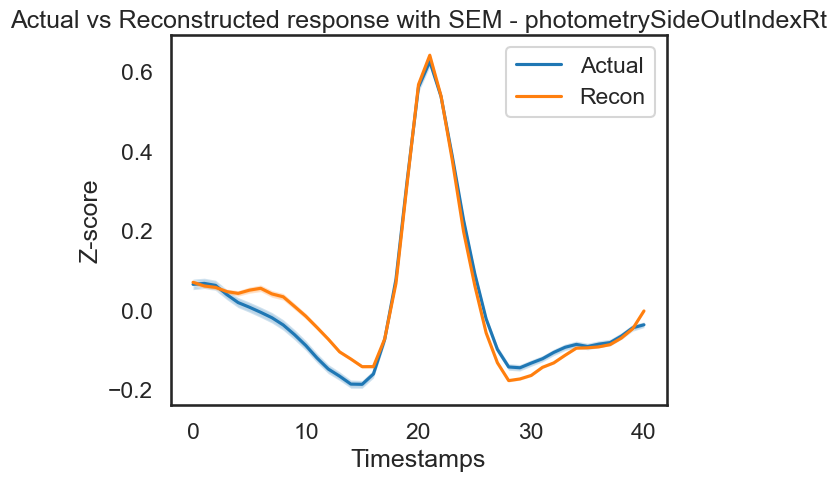

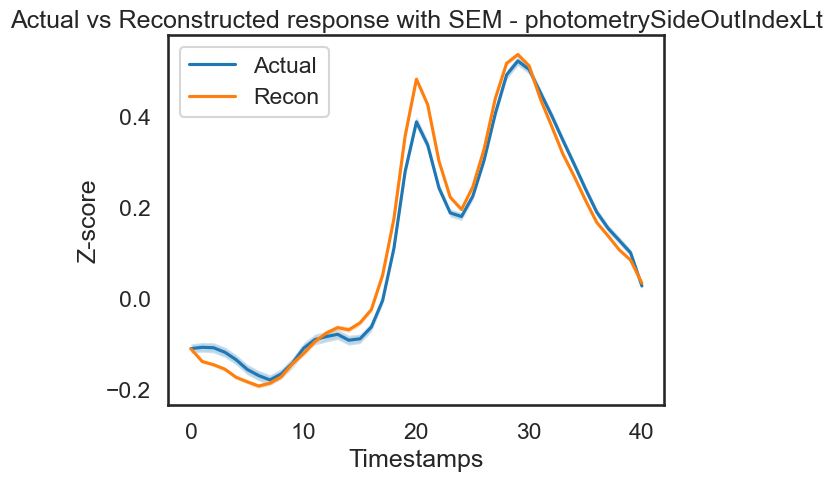

In [26]:
# Plot actual vs reconstructed
utils.plot_actual_v_reconstructed(config, aligned_dataStream, recon_dataStream, save=True, save_path=save_path)

## Additional validation: 

In addition to using k-folds cross-validation, you can also use the `leave_one_out_cross_val` method to validate your model. This method will leave one predictor out and fit the model on the remaining predictors. A `model_list` will be returned with the `model` and `predictions` for each left out predictor.

Fitting Ridge model...
Model fit complete
Predictor left out: photometryCenterInIndexRt, Score: 0.000606808871114306, adding to model list...
Fitting Ridge model...
Model fit complete
Predictor left out: photometryCenterInIndexLt, Score: 0.000666567263174711, adding to model list...
Fitting Ridge model...
Model fit complete
Predictor left out: photometryCenterOutIndexRt, Score: 0.0006880767213839345, adding to model list...
Fitting Ridge model...
Model fit complete
Predictor left out: photometryCenterOutIndexLt, Score: 0.00067048714124196, adding to model list...
Fitting Ridge model...
Model fit complete
Predictor left out: photometrySideInIndexr, Score: 0.000674542227233843, adding to model list...
Fitting Ridge model...
Model fit complete
Predictor left out: photometrySideInIndexnr, Score: 0.0006754958316347315, adding to model list...
Fitting Ridge model...
Model fit complete
Predictor left out: photometrySideInIndexRt, Score: 0.0006688195346993275, adding to model list...
Fitting R

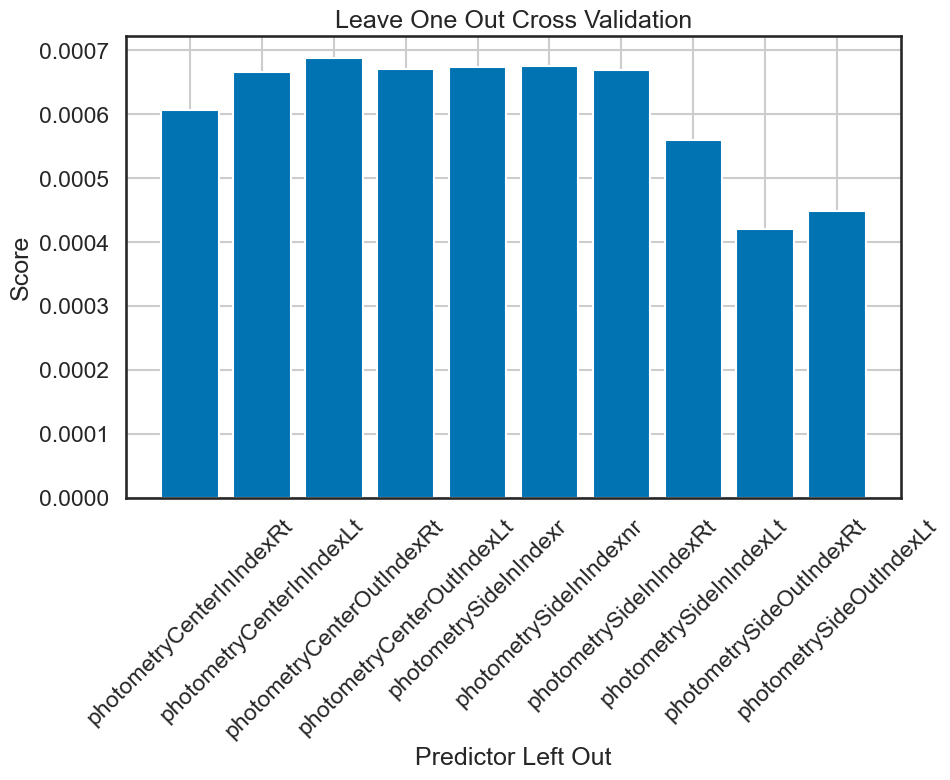

In [27]:
model_list = glm_fit.leave_one_out_cross_val(config, X_train, X_test, y_train, y_test)

#Save your model_list
import pickle
LO_CV_path = (config['Project']['project_path'] + '/models/LO_CV_models.pkl')
with open(LO_CV_path, 'wb') as f:
        pickle.dump(model_list, f)